# PINN解波动方程代码（Pytorch）
作者：刘祺
日期：20211124

时间：20211103
改动：   

1.加入了画损失函数下降图的功能  
2.加入了绘图功能  
3.将DNN部分的定义改为使用sequential而不是简单的传播形式，更加美观  

时间：20211110  
改动：  

1.加入了Animator类，实现了损失函数下降的实时可视化

时间：20211124  
改动：  

1.将数据处理环节更加简便，加入了模型存储功能  

时间：20211227  
改动：  
1.加入tensorboard可视化loss下降曲线  
2.删除Animator类

## 模块导入

In [97]:
import sys
import torch
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import torch.nn as nn
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
import IPython
from IPython import display
import torch.optim.lr_scheduler as lr_scheduler

如果存在gpu，则使用gpu进行计算

In [98]:
# 是否支持cuda
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#是否支持gpu计算
print(torch.cuda.is_available())

True


## 定义DNN结构

In [99]:
class DNN(torch.nn.Module):
    def __init__(self,layers):
        super(DNN, self).__init__()
        self.depth=len(layers)-1
        self.activation=torch.nn.Tanh
        layer_list=list()
        for i in range(self.depth-1):
            layer_list.append(
                ('layer_%d'%i,torch.nn.Linear(layers[i],layers[i+1]))
            )
            layer_list.append(('activation_%d'%i,self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)#如果不加入ordereddict则字典中元素顺序可能会改变
        self.layers=torch.nn.Sequential(layerDict)
    def forward(self,x):
        out=self.layers(x)
        return out


# 有关PINN参数的设置（包含边界条件初值条件等）

In [100]:
layers=[3,40,40,40,40,1]
net=DNN(layers)
print(net,layers)
net=net.to(device)

#激活函数以及优化器
mse_cost_function = torch.nn.MSELoss(reduction='mean')  # Mean squared error
optimizer = torch.optim.Adam(net.parameters(),lr=0.005)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=3, out_features=40, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=40, out_features=40, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=40, out_features=40, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=40, out_features=40, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=40, out_features=1, bias=True)
  )
) [3, 40, 40, 40, 40, 1]


In [101]:
#参数初始化
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=3, out_features=40, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=40, out_features=40, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=40, out_features=40, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=40, out_features=40, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=40, out_features=1, bias=True)
  )
)

## 方程对应的函数

In [102]:
def wave_function(x,y,t,net):
    u=net(torch.cat([x,y,t],dim=1))

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t.sum(), t, create_graph=True)[0]

    loss_wf=u_tt-4*(u_xx+u_yy)

    return loss_wf


## 边界条件对应的损失函数

In [103]:
def initial_condition(x,y,t,net):
    u=net(torch.cat([x,y,t],dim=1))
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]

    return u_t


## 配置点以及初值点边值点的处理

In [104]:
#参数设置
x=np.linspace(0,4*np.pi,37)
#x=np.random.uniform(0.0,4*np.pi,37)
y=np.linspace(0,4*np.pi,37)
#y=np.random.uniform(0.0,4*np.pi,37)
t=np.linspace(0,np.pi*np.sqrt(8),37)
x_mesh,y_mesh,t_mesh=np.meshgrid(x,y,t)
x_use=x_mesh.reshape((-1,1))
y_use=y_mesh.reshape((-1,1))
t_use=t_mesh.reshape((-1,1))
xyt_use=np.hstack((x_use,y_use,t_use))
#初值条件
x_cz_mesh,y_cz_mesh=np.meshgrid(x,y)
x_cz_use=x_cz_mesh.reshape((-1,1))
y_cz_use=y_cz_mesh.reshape((-1,1))
t_cz=np.zeros_like(x_cz_use)
xyt_cz=np.hstack((x_cz_use,y_cz_use,t_cz))
u_cz=2*np.sin(xyt_cz[:,0:1]/4)*np.sin(xyt_cz[:,1:2]/4)
ut_cz=4/np.sqrt(8)*np.sin(xyt_cz[:,0:1]*np.pi/4)*np.sin(xyt_cz[:,1:2]*np.pi/4)
#边界条件
#x=0
x_x0=np.zeros_like(y)
x_x0_mesh,y_x0_mesh,t_x0_mesh=np.meshgrid(x_x0,y,t)
x_x0_use=x_x0_mesh.reshape((-1,1))
y_x0_use=y_x0_mesh.reshape((-1,1))
t_x0_use=t_x0_mesh.reshape((-1,1))
xyt_x0_use=np.hstack((x_x0_use,y_x0_use,t_x0_use))
#x=4pi
x_xa=4*np.pi*np.ones_like(y)
x_xa_mesh,y_xa_mesh,t_xa_mesh=np.meshgrid(x_xa,y,t)
x_xa_use=x_xa_mesh.reshape((-1,1))
y_xa_use=y_xa_mesh.reshape((-1,1))
t_xa_use=t_xa_mesh.reshape((-1,1))
xyt_xa_use=np.hstack((x_xa_use,y_xa_use,t_xa_use))
#y=0
y_y0=np.zeros_like(y)
x_y0_mesh,y_y0_mesh,t_y0_mesh=np.meshgrid(x,y_y0,t)
x_y0_use=x_y0_mesh.reshape((-1,1))
y_y0_use=y_y0_mesh.reshape((-1,1))
t_y0_use=t_y0_mesh.reshape((-1,1))
xyt_y0_use=np.hstack((x_y0_use,y_y0_use,t_y0_use))
#y=4pi
y_ya=4*np.pi*np.ones_like(y)
x_ya_mesh,y_ya_mesh,t_ya_mesh=np.meshgrid(x,y_ya,t)
x_ya_use=x_ya_mesh.reshape((-1,1))
y_ya_use=y_ya_mesh.reshape((-1,1))
t_ya_use=t_ya_mesh.reshape((-1,1))
xyt_ya_use=np.hstack((x_ya_use,y_ya_use,t_ya_use))

xyt_boundary=np.vstack((xyt_x0_use,xyt_xa_use,xyt_y0_use,xyt_ya_use))


x_mesh_pre,y_mesh_pre=np.meshgrid(x,y)
x_use_pre=np.reshape(x_mesh_pre,(-1,1))
y_use_pre=np.reshape(y_mesh_pre,(-1,1))
t_pred1=np.ones_like(x_use_pre)*1.51
t_pred2=np.ones_like(x_use_pre)*5.60
xyt_pred1=np.hstack((x_use_pre,y_use_pre,t_pred1))
xyt_pred2=np.hstack((x_use_pre,y_use_pre,t_pred2))
print(x_use.shape)
print(xyt_x0_use.shape)



(50653, 1)
(50653, 3)


## 将numpy数据转化为可以用于PINN的数据

In [105]:
x_train=torch.tensor(xyt_use[:,0:1],requires_grad=True).float().to(device)
y_train=torch.tensor(xyt_use[:,1:2],requires_grad=True).float().to(device)
t_train=torch.tensor(xyt_use[:,2:3],requires_grad=True).float().to(device)
x_cz=torch.tensor(xyt_cz[:,0:1],requires_grad=True).float().to(device)
y_cz=torch.tensor(xyt_cz[:,1:2],requires_grad=True).float().to(device)
t_cz=torch.tensor(xyt_cz[:,2:3],requires_grad=True).float().to(device)
u_cz=torch.tensor(u_cz).float().to(device)
ut_cz=torch.tensor(ut_cz).float().to(device)
x_bz = torch.tensor(xyt_boundary[:, 0:1], requires_grad=True).float().to(device)
y_bz = torch.tensor(xyt_boundary[:, 1:2], requires_grad=True).float().to(device)
t_bz = torch.tensor(xyt_boundary[:, 2:3], requires_grad=True).float().to(device)

xyt_cz_tensor=torch.tensor(xyt_cz,requires_grad=True).float().to(device)
xyt_boundary_tensor=torch.tensor(xyt_boundary,requires_grad=True).float().to(device)
print(xyt_boundary_tensor.shape)

torch.Size([202612, 3])


# 开始训练

In [106]:
#引入tensorboard
from tensorboardX import SummaryWriter
writer=SummaryWriter()


max_epoch=1000
Loaded_loss = np.zeros(max_epoch)
for epoch in range(max_epoch):
    optimizer.zero_grad()
    if hasattr(torch.cuda, 'empty_cache'):  # 释放显存
        torch.cuda.empty_cache()
    

    loss_wf=torch.mean(wave_function(x_train,y_train,t_train,net)**2)
    loss_cz=torch.mean(((net(xyt_cz_tensor))-u_cz)**2)
    loss_cz_ut=torch.mean((initial_condition(x_cz,y_cz,t_cz,net)-ut_cz)**2)
    loss_bz=torch.mean(net(xyt_boundary_tensor)**2)

    loss=loss_wf+loss_cz+loss_cz_ut+loss_bz
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    with torch.autograd.no_grad():
        Loaded_loss[epoch] = loss.data.cpu().numpy()
        if epoch%10==0:
            print(epoch, "Training Loss:", loss.data)
    writer.add_scalar('loss',loss,epoch)
writer.close()


#predict
def predict(X):
        x=torch.tensor(X[:,0:1],requires_grad=True).float().to(device)
        y =torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        t=torch.tensor(X[:,2:3],requires_grad=True).float().to(device)

        net.eval()
        canshu=net(torch.cat([x,y,t],dim=1))
        canshu=canshu.detach().cpu().numpy()

        return canshu
pred1=predict(xyt_pred1)
pred2=predict(xyt_pred2)
scipy.io.savemat('111.mat',{'test1':pred1,'test2':pred2})



0 Training Loss: tensor(1.3891, device='cuda:0')
10 Training Loss: tensor(1.0705, device='cuda:0')
20 Training Loss: tensor(0.9900, device='cuda:0')
30 Training Loss: tensor(0.9562, device='cuda:0')
40 Training Loss: tensor(0.9331, device='cuda:0')
50 Training Loss: tensor(0.9176, device='cuda:0')
60 Training Loss: tensor(0.9094, device='cuda:0')
70 Training Loss: tensor(0.8970, device='cuda:0')
80 Training Loss: tensor(0.8744, device='cuda:0')
90 Training Loss: tensor(0.7993, device='cuda:0')
100 Training Loss: tensor(0.6762, device='cuda:0')
110 Training Loss: tensor(0.6239, device='cuda:0')
120 Training Loss: tensor(0.5866, device='cuda:0')
130 Training Loss: tensor(0.5673, device='cuda:0')
140 Training Loss: tensor(0.5510, device='cuda:0')
150 Training Loss: tensor(0.5341, device='cuda:0')
160 Training Loss: tensor(0.5468, device='cuda:0')
170 Training Loss: tensor(0.5078, device='cuda:0')
180 Training Loss: tensor(0.5035, device='cuda:0')
190 Training Loss: tensor(0.4877, device='

## 存储模型

In [107]:
torch.save(net.state_dict(), 'wave function.params ')#state_dict存储状态参数，格式为（layer_n.weight,data） 

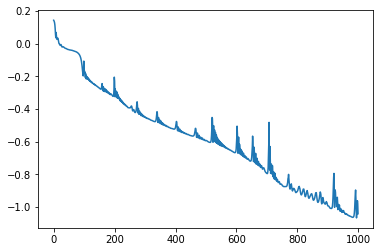

In [108]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
## 画损失函数图线
fig3 = plt.figure("Loss_log10")
bx = fig3.add_subplot(111)
bx.plot(np.log10(Loaded_loss))

plt.show()

In [109]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

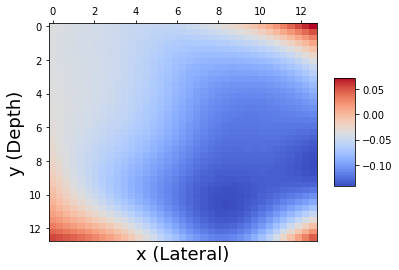

<Figure size 432x288 with 0 Axes>

In [110]:
fig1 = plt.figure("velocity")
ax = fig1.add_subplot(111)
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')  # 这里设置y轴反向表示深度，x轴坐标放在顶部

x_grid = np.linspace(0.0, 4*np.pi, 37)
y_grid = np.linspace(0.0, 4*np.pi, 37)
X, Y = np.meshgrid(x, y)
u=pred2.reshape((37,37))

## 设置xy轴标签
plt.gca().set_xlabel("x (Lateral)", fontsize=18)
plt.gca().set_ylabel("y (Depth)", fontsize=18)

field_v = ax.pcolor(X, Y, u, cmap=cm.get_cmap('coolwarm'), shading='auto')
fig1.colorbar(field_v, shrink=0.5, aspect=5)  # 添加颜色条
plt.show()
plt.savefig("l.png")


